In [35]:
import numpy as np
import torch
import umap
import pandas as pd
import molplotly
import plotly.express as px
import random
from rdkit import Chem
import msml.utils.mols as mu
from msml.definitions import *
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [50]:
df_nist = pd.read_pickle(NIST20 / 'nist20_clean_A.pkl')
df_nist['EXACT MASS'] = df_nist['EXACT MASS'].astype(float)
# df = df[df['EXACT MASS'] <= 1000]
df_nist['FORMULA'] = df_nist['FORMULA'].apply(mu.formula_to_dict)
df_nist['SMILES'] = df_nist['ROMol'].apply(Chem.MolToSmiles)
df_nist

,NAME,NOTES,PRECURSOR TYPE,SPECTRUM TYPE,PRECURSOR M/Z,INSTRUMENT TYPE,INSTRUMENT,SAMPLE INLET,IONIZATION,IN-SOURCE VOLTAGE,...,PARSED PEAKS,MSnSpectrum,#C,#O,#N,#S,#P,#Cl,#F,SMILES
0,"1,2-Dioleoyl-sn-glycero-3-phospho-(1'-myo-inos...",Water/isopropanol/Formic acid; added_Vial_ID=6039,[M+H]+,MS2,863.5644,Q-TOF,Agilent QTOF 6530,direct flow injection,ESI,150,...,"[[495.29, 601.49, 602.51, 603.52, 862.55, 862....",<msml.utils.spectra.MSnSpectrum object at 0x59...,45,13,0,0,1,0,0,CCCCCCCC/C=C\CCCCCCCC(=O)OCC(CO[P@SP](=O)(O)OC...
1,"1,2-dioleoyl-sn-glycero-3-phosphatidylcholine",Consensus spectrum; Water/isopropanol/Formic a...,[M+H]+,MS2,786.6007,Q-TOF,Agilent QTOF 6530,direct flow injection,ESI,150,...,"[[104.11, 184.07, 785.58, 786.6, 787.61, 0.0, ...",<msml.utils.spectra.MSnSpectrum object at 0x59...,44,8,1,0,1,0,0,CCCCCCCC/C=C\CCCCCCCC(=O)OC[C@H](COP(=O)([O-])...
2,"1,2-dioleoyl-sn-glycero-3-phosphatidylcholine",Consensus spectrum; Water/isopropanol/Formic a...,[M+H]+,MS2,786.6007,Q-TOF,Agilent QTOF 6530,direct flow injection,ESI,150,...,"[[86.1, 125.0, 184.07, 185.07, 0.0, 0.0, 0.0, ...",<msml.utils.spectra.MSnSpectrum object at 0x59...,44,8,1,0,1,0,0,CCCCCCCC/C=C\CCCCCCCC(=O)OC[C@H](COP(=O)([O-])...
3,"1,2-dioleoyl-sn-glycero-3-phosphatidylcholine",Water/isopropanol/Formic acid; added_Vial_ID=1...,[M+Na]+,MS2,808.5827,Q-TOF,Agilent QTOF 6530,direct flow injection,ESI,150,...,"[[69.07, 69.1, 86.1, 137.14, 146.97, 146.99, 1...",<msml.utils.spectra.MSnSpectrum object at 0x59...,44,8,1,0,1,0,0,CCCCCCCC/C=C\CCCCCCCC(=O)OC[C@H](COP(=O)([O-])...
4,"1,2-dioleoyl-sn-glycero-3-phosphatidylcholine",Water/isopropanol/Formic acid; added_Vial_ID=1...,[M+Na]+,MS2,808.5827,Q-TOF,Agilent QTOF 6530,direct flow injection,ESI,150,...,"[[86.1, 100.99, 101.03, 124.13, 124.15, 146.98...",<msml.utils.spectra.MSnSpectrum object at 0x59...,44,8,1,0,1,0,0,CCCCCCCC/C=C\CCCCCCCC(=O)OC[C@H](COP(=O)([O-])...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
355214,(3'-sulfo)Gal.beta.-Cer(d18:1/22:0),micromol/L in water/acetonitrile/formic acid (...,[M+H]+,MS2,864.6229,HCD,Orbitrap Fusion Lumos,direct flow injection,ESI,NaN,...,"[[236.2361, 237.2397, 247.2407, 252.2673, 253....",<msml.utils.spectra.MSnSpectrum object at 0x3b...,46,11,1,1,0,0,0,CCCCCCCCCCCCC/C=C/[C@@H](O)[C@H](CO[C@@H]1O[C@...
355215,(3'-sulfo)Gal.beta.-Cer(d18:1/22:0),micromol/L in water/acetonitrile/formic acid (...,[M+H]+,MS2,864.6229,HCD,Orbitrap Fusion Lumos,direct flow injection,ESI,NaN,...,"[[236.236, 252.2672, 253.2704, 256.263, 262.25...",<msml.utils.spectra.MSnSpectrum object at 0x3b...,46,11,1,1,0,0,0,CCCCCCCCCCCCC/C=C/[C@@H](O)[C@H](CO[C@@H]1O[C@...
355216,(3'-sulfo)Gal.beta.-Cer(d18:1/22:0),micromol/L in water/acetonitrile/formic acid (...,[M+H]+,MS2,864.6229,HCD,Orbitrap Fusion Lumos,direct flow injection,ESI,NaN,...,"[[184.0253, 236.2368, 252.2678, 254.2838, 262....",<msml.utils.spectra.MSnSpectrum object at 0x3b...,46,11,1,1,0,0,0,CCCCCCCCCCCCC/C=C/[C@@H](O)[C@H](CO[C@@H]1O[C@...
355217,(3'-sulfo)Gal.beta.-Cer(d18:1/22:0),micromol/L in water/acetonitrile/formic acid (...,[M+H]+,MS2,864.6229,HCD,Orbitrap Fusion Lumos,direct flow injection,ESI,NaN,...,"[[254.2836, 264.2672, 265.2708, 309.2098, 311....",<msml.utils.spectra.MSnSpectrum object at 0x3b...,46,11,1,1,0,0,0,CCCCCCCCCCCCC/C=C/[C@@H](O)[C@H](CO[C@@H]1O[C@...


In [37]:
# df_u_smiles = df.drop_duplicates(subset=['SMILES'])
# df_u_smiles = df_u_smiles.reset_index(drop=True)
# np_classes = mu.np_classify(df_u_smiles['SMILES'].tolist(), sleep_each_n_requests=10)
# np_classes

In [51]:
embs_nist = torch.load(NIST20 / 'nist20_clean_A_dreams_embs.pt', map_location='cpu')

In [52]:
disjoint_inchi14s = pd.read_pickle(EXPERIMENTS_DIR / 'spec_sim/data/nist_inchi14s_disjoint_from_mona_contrastive.pkl')
df_nist['inchi14'] = df_nist['ROMol'].progress_apply(mu.mol_to_inchi14)

100%|██████████| 355219/355219 [00:37<00:00, 9368.09it/s] 


In [53]:
disjoint_idx = df_nist[df_nist['inchi14'].isin(disjoint_inchi14s)].index.tolist()
len(disjoint_idx)

304445

In [61]:
seed = 123
random.seed(seed)
rand_idx = random.sample(disjoint_idx, 100_000)
df = df_nist.iloc[rand_idx].copy()
embs = embs_nist[rand_idx]

reducer = umap.UMAP(metric='cosine', min_dist=0.2)#, random_state=seed)
umap_embs = reducer.fit_transform(embs.numpy())
umap_embs.shape

(100000, 2)

In [62]:
def is_carbohydrate(formula):
    return set(formula.keys()) <= {'C', 'H', 'O'}
def is_halogenated(formula):
    return sum([(formula[e] if e in formula else 0) for e in ['F', 'Cl', 'Br', 'I']]) > 0
def mol_type(f):
    if is_carbohydrate(f):
        return 'Carbohydrate'
    elif set(f.keys()) <= {'C', 'H', 'O', 'N'}:
        return 'Carbohydrate with nitrogen'
    elif set(f.keys()) <= {'C', 'H', 'O', 'N', 'S'} and 'N' in f and 'S' in f:
        return 'Carbohydrate with nitrogen and sulfur'
    elif is_halogenated(f):
        return 'Compound with halogens'
    else:
        return 'Other'
df['Mol type'] = df['FORMULA'].apply(mol_type)
df['Mol type'] = df['FORMULA'].apply(mol_type)
df['Num. rings'] = df['ROMol'].apply(lambda m: len(Chem.GetSSSR(m)))

In [69]:
fig = px.scatter(x=umap_embs[:, 0], y=umap_embs[:, 1], color=df['Mol type'].astype('category').cat.codes, width=700, height=600)#, color_discrete_sequence=px.colors.qualitative.Antique)`
df['i'] = df.index.tolist()
app = molplotly.add_molecules(fig=fig, df=df, smiles_col='SMILES', title_col='i')
app.run_server(mode='inline', port=8700, height=600)

Dash is running on http://127.0.0.1:8700/



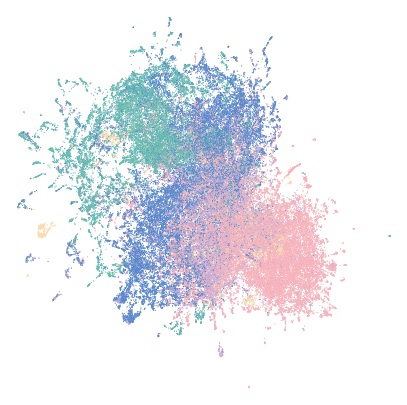

In [70]:
import seaborn as sns
import matplotlib.pyplot as plt
from msml.utils.plots import init_plotting, get_nature_hex_colors, save_fig
init_plotting(figsize=(5, 5))
palette = get_nature_hex_colors()
# palette[4] = '#AD95D1'
palette = [palette[1], palette[0], palette[2], palette[4], palette[3]]

sns.scatterplot(
    x=umap_embs[:, 0],
    y=umap_embs[:, 1],
    hue=df['Mol type'],
    palette=palette,
    # markers={'Carbohydrate': 'o', 'Halogenated': 'X', 'Other': 'D'},
    alpha=1,
    s=0.6,
)
min_x, max_x = min(umap_embs[:, 0]), max(umap_embs[:, 0])
# min_x, max_x = 2.1, 17.5
margin_x = (max_x - min_x) * 0.02
min_y, max_y = min(umap_embs[:, 1]), max(umap_embs[:, 1])
# min_y, max_y = -5.03, max(umap_embs[:, 1])
margin_y = (max_y - min_y) * 0.02
plt.xlim(min_x - margin_x, max_x + margin_x)
plt.ylim(min_y - margin_y, max_y + margin_y)
plt.grid(None)
plt.xticks([])
plt.yticks([])
# plt.xlabel('UMAP 1')
# plt.ylabel('UMAP 2')
plt.legend(markerscale=5)
plt.legend('',frameon=False)
plt.box(False)
save_fig('umap_dreams.png', dpi=700)
plt.show()

In [9]:
# the cook book example
def GetRingSystems(mol, includeSpiro=False):
    ri = mol.GetRingInfo()
    systems = []
    for ring in ri.AtomRings():
        ringAts = set(ring)
        nSystems = []
        for system in systems:
            nInCommon = len(ringAts.intersection(system))
            if nInCommon and (includeSpiro or nInCommon>1):
                ringAts = ringAts.union(system)
            else:
                nSystems.append(system)
        nSystems.append(ringAts)
        systems = nSystems
    return systems
from tqdm import tqdm
tqdm.pandas()

def size_of_largest_ring_system(mol):
    rs =  GetRingSystems(mol)
    if not rs:
        return 0
    return max([len(s) for s in rs])
df['Size of largest ring ststem'] = df['ROMol'].progress_apply(size_of_largest_ring_system)

  1%|          | 956/100000 [00:03<05:41, 289.94it/s]

KeyboardInterrupt



In [92]:
from rdkit import Chem

def calculate_mean_atom_degree(molecule):
    # Get the number of atoms in the molecule
    num_atoms = molecule.GetNumAtoms()

    # Calculate the sum of degrees of all atoms
    sum_degrees = sum(atom.GetDegree() for atom in molecule.GetAtoms())

    # Calculate the mean atom degree
    mean_atom_degree = sum_degrees / num_atoms if num_atoms > 0 else 0

    return mean_atom_degree

def calculate_mean_heavy_atom_degree(molecule):
    # Get the heavy atoms in the molecule
    heavy_atoms = [atom for atom in molecule.GetAtoms() if not atom.GetAtomicNum() == 1]

    # Calculate the sum of degrees of all heavy atoms
    sum_degrees = sum(atom.GetDegree() for atom in heavy_atoms)

    print([atom.GetDegree() for atom in heavy_atoms])

    # Calculate the mean atom degree for heavy atoms
    num_heavy_atoms = len(heavy_atoms)
    mean_atom_degree = sum_degrees / num_heavy_atoms if num_heavy_atoms > 0 else 0

    return mean_atom_degree

def calculate_fraction_of_2_atom_degree(molecule):
    # Get the heavy atoms in the molecule
    heavy_atoms = [atom for atom in molecule.GetAtoms() if not atom.GetAtomicNum() == 1]

    # Calculate the sum of degrees of all heavy atoms
    num_3_degrees = sum([atom.GetDegree() == 2 for atom in heavy_atoms])

    # Calculate the mean atom degree for heavy atoms
    num_heavy_atoms = len(heavy_atoms)
    mean_atom_degree = num_3_degrees / num_heavy_atoms if num_heavy_atoms > 0 else 0

    return mean_atom_degree

df['Fraction of 2 atom degree'] = df['ROMol'].progress_apply(calculate_fraction_of_2_atom_degree)

100%|██████████| 100000/100000 [00:03<00:00, 25495.15it/s]


<AxesSubplot: >

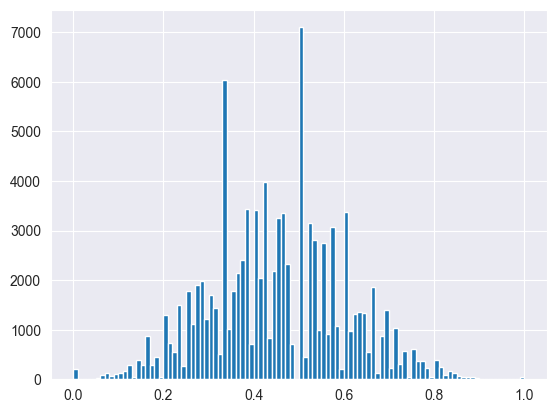

In [11]:
df['Fraction of 2 atom degree'].hist(bins=100)

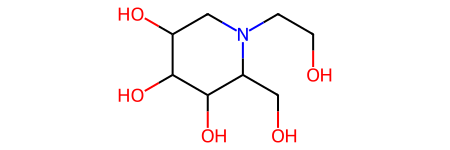

In [12]:
df.loc[83693]['ROMol']

In [91]:
def calculate_fraction_double_bonds(molecule):
    # Get the number of double bonds in the molecule
    num_double_bonds = sum(bond.GetBondType() == Chem.BondType.DOUBLE for bond in molecule.GetBonds())

    # Get the total number of bonds in the molecule
    num_total_bonds = molecule.GetNumBonds()

    # Calculate the fraction of double bonds
    fraction_double_bonds = num_double_bonds / num_total_bonds if num_total_bonds > 0 else 0

    return fraction_double_bonds

df['Fraction of double bonds'] = df['ROMol'].progress_apply(calculate_fraction_double_bonds)

100%|██████████| 100000/100000 [00:04<00:00, 20449.71it/s]


In [14]:
def find_max_bond_type(molecule):
    # Get the bonds in the molecule
    bonds = molecule.GetBonds()

    # Initialize max bond type
    max_bond_type = Chem.BondType.SINGLE

    # Iterate over bonds to find the maximum bond type
    for bond in bonds:
        if bond.GetBondTypeAsDouble() > max_bond_type:
            max_bond_type = bond.GetBondTypeAsDouble()

    return max_bond_type
df['Max bond type'] = df['ROMol'].progress_apply(find_max_bond_type)

100%|██████████| 100000/100000 [00:03<00:00, 32920.64it/s]


<AxesSubplot: >

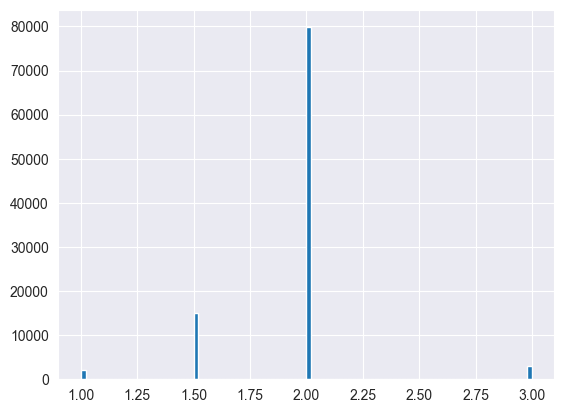

In [15]:
df['Max bond type'].hist(bins=100)

In [16]:
len(df.loc[83693]['ROMol'].GetBonds()), len(df.loc[83693]['ROMol'].GetAtoms())

(14, 14)

<AxesSubplot: >

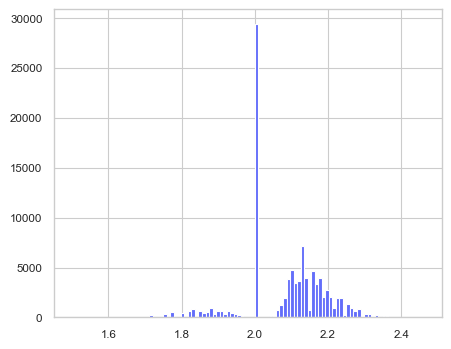

In [467]:
df['Mean heavy atom degree'].hist(bins=100)

In [79]:
# df.to_pickle('data/df_umap.pkl')
# torch.save(umap_embs, 'data/embs_umap.pt')
df = pd.read_pickle('data/df_umap.pkl')
umap_embs = torch.load('data/embs_umap.pt')

In [18]:
df['Mol type'].value_counts()

2    46205
3    32142
1    21653
Name: Mol type, dtype: int64

In [71]:
fig = px.scatter(x=umap_embs[:, 0], y=umap_embs[:, 1], color=df['Mol type'].astype('category').cat.codes, width=700, height=600)#, color_discrete_sequence=px.colors.qualitative.Antique)`
df['i'] = df.index.tolist()
app = molplotly.add_molecules(fig=fig, df=df, smiles_col='SMILES', title_col='i')
app.run_server(mode='inline', port=8700, height=600)

Dash is running on http://127.0.0.1:8700/



'NC(=O)c1cccc(-c2cccc(OC(=O)NC3CCCCC3)c2)c1'

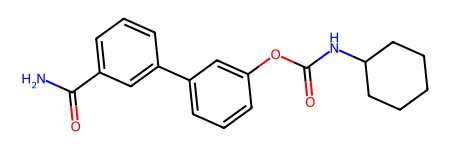

In [118]:
s = df.loc[80496]['SMILES']
display(s)
display(Chem.MolFromSmiles(s))

'CC(C)CC(c1c(O)c(C=O)c(O)c(C=O)c1O)C1(C)CCC2C1C1C(CCC2(C)O)C1(C)C'

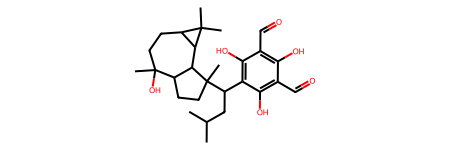

In [117]:
s = df.loc[255571]['SMILES']
display(s)
display(Chem.MolFromSmiles(s))

'CCCCCCCCCCCCCCCCOCC(CO[P@SP](=O)([O-])OCC[N+](C)(C)C)SC(C)=O'

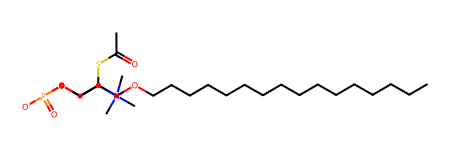

In [116]:
s = df.loc[56062]['SMILES']
display(s)
display(Chem.MolFromSmiles(s))

'COc1cc(NS(=O)(=O)c2ccc(N)cc2)ncn1'

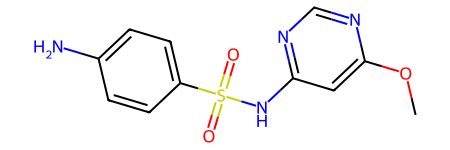

In [115]:
s = df.loc[161540]['SMILES']
display(s)
display(Chem.MolFromSmiles(s))

'Cc1ccc(-c2n[nH]cc2C=O)cc1'

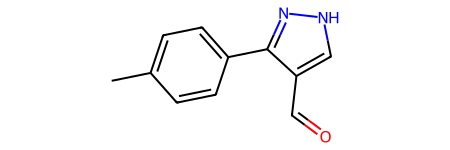

In [114]:
s = df.loc[184770]['SMILES']
display(s)
display(Chem.MolFromSmiles(s))

'O=C(O)Cc1ccc(F)c(Br)c1'

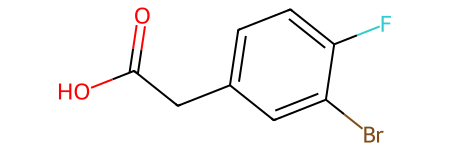

In [111]:
s = df.loc[352049]['SMILES']
display(s)
display(Chem.MolFromSmiles(s))

'Brc1cnc2cccc(Br)c2c1'

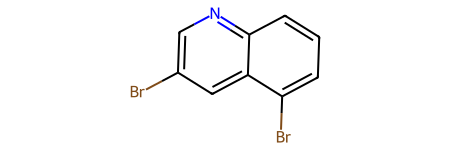

In [109]:
s = df.loc[352767]['SMILES']
display(s)
display(Chem.MolFromSmiles(s))

In [562]:
df.loc[68016]['SMILES']

'CC(C)(CC(=O)O)CC(=O)O'

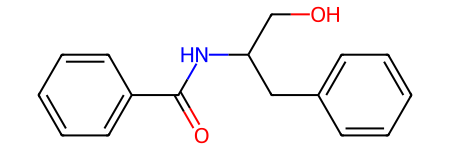

In [547]:
df.loc[179720]['ROMol']

In [552]:
df.loc[179720]['SMILES']

'O=C(NC(CO)Cc1ccccc1)c1ccccc1'

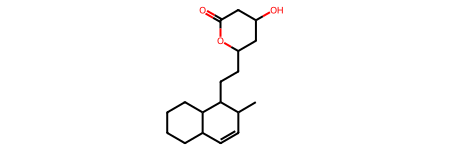

In [546]:
df.loc[209432]['ROMol']

In [554]:
df.loc[209432]['SMILES']

'CC1C=CC2CCCCC2C1CCC1CC(O)CC(=O)O1'

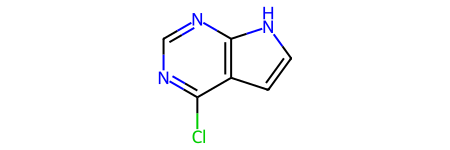

In [541]:
df.loc[145152]['ROMol']

In [555]:
df.loc[145152]['SMILES']

'Clc1ncnc2[nH]ccc12'

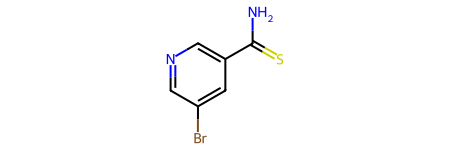

In [539]:
df.loc[328971]['ROMol']

In [556]:
df.loc[328971]['SMILES']

'NC(=S)c1cncc(Br)c1'

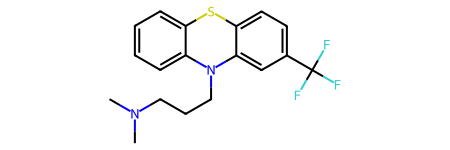

In [536]:
df.loc[74214]['ROMol']

In [557]:
df.loc[74214]['SMILES']

'CN(C)CCCN1c2ccccc2Sc2ccc(C(F)(F)F)cc21'

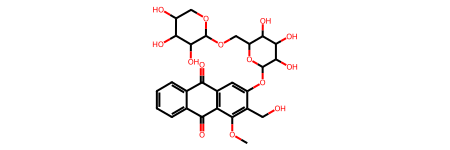

In [535]:
df.loc[207012]['ROMol']

In [558]:
df.loc[207012]['SMILES']

'COc1c(CO)c(OC2OC(COC3OCC(O)C(O)C3O)C(O)C(O)C2O)cc2c1C(=O)c1ccccc1C2=O'

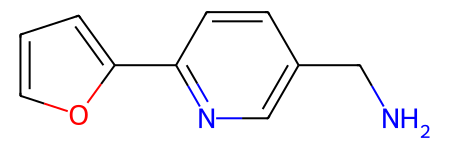

In [533]:
df.loc[325744]['ROMol']

In [559]:
df.loc[325744]['SMILES']

'NCc1ccc(-c2ccco2)nc1'

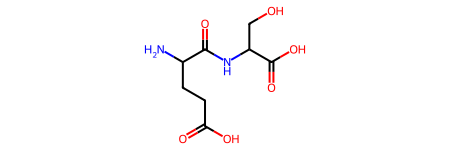

In [532]:
df.loc[15480]['ROMol']

In [560]:
df.loc[15480]['SMILES']

'NC(CCC(=O)O)C(=O)NC(CO)C(=O)O'

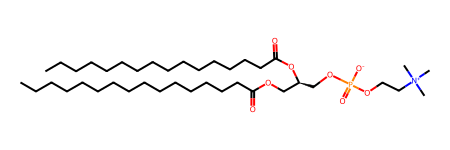

In [542]:
df.loc[29693]['ROMol']

In [561]:
df.loc[29693]['SMILES']

'CCCCCCCCCCCCCCCC(=O)OC[C@H](COP(=O)([O-])OCC[N+](C)(C)C)OC(=O)CCCCCCCCCCCCCCC'

In [464]:
calculate_mean_atom_degree(df.loc[83693]['ROMol'])

2.0

In [104]:
df['#Br'] = df['FORMULA'].apply(lambda f: f['Br'] if 'Br' in f else 0)
df['#I'] = df['FORMULA'].apply(lambda f: f['I'] if 'I' in f else 0)
df['#F'] = df['FORMULA'].apply(lambda f: f['F'] if 'F' in f else 0)

In [84]:
def bin_2d_umap(umap_embs, feature='#O', n_bins=200):
    grid = np.zeros((n_bins - 1, n_bins - 1))
    x_bins = np.linspace(umap_embs[:, 0].min(), umap_embs[:, 0].max(), n_bins)
    y_bins = np.linspace(umap_embs[:, 1].min(), umap_embs[:, 1].max(), n_bins)
    for i, (x_min, x_max) in enumerate(zip(x_bins, x_bins[1:])):
        for j, (y_min, y_max) in enumerate(zip(y_bins, y_bins[1:])):
            mean_mz = df.iloc[np.where(
                (umap_embs[:, 1] >= y_min) & (umap_embs[:, 1] < y_max) & (umap_embs[:, 0] >= x_min) & (umap_embs[:, 0] < x_max)
            )[0].tolist()][feature].mean()
            if np.isnan(mean_mz):
                grid[i, j] = 0
            else:
                grid[i, j] = mean_mz
    return x_bins, y_bins, grid.T

In [88]:
x_bins, y_bins, grid_contour = bin_2d_umap(umap_embs, feature='#C')
grid_contour = (grid_contour > 0).astype(int)

/var/folders/73/x57b4d9x09qbcqjjd5ccz_6r0000gn/T/ipykernel_1777/485996954.py:14: UserWarning:

linewidths is ignored by contourf



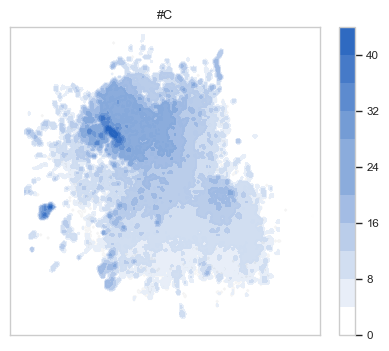

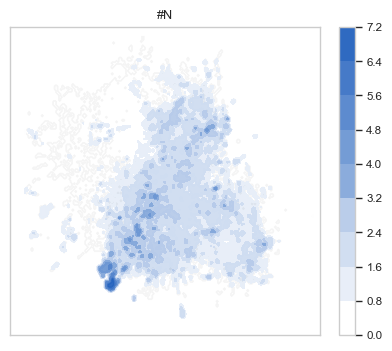

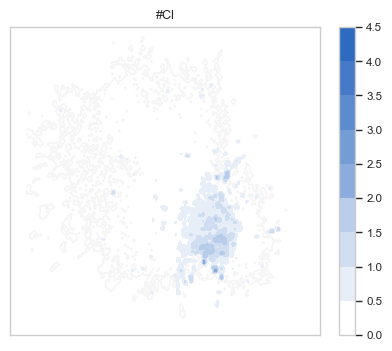

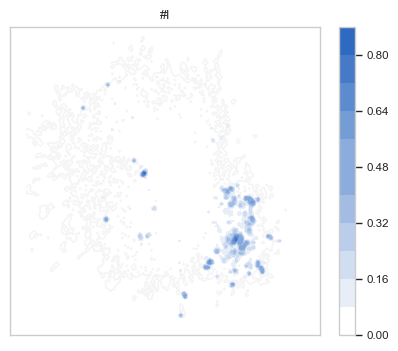

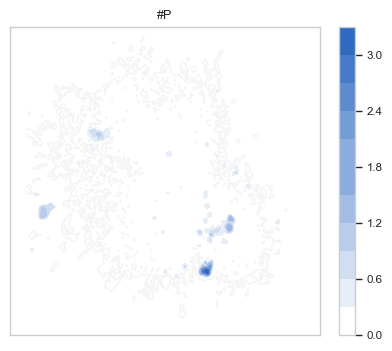

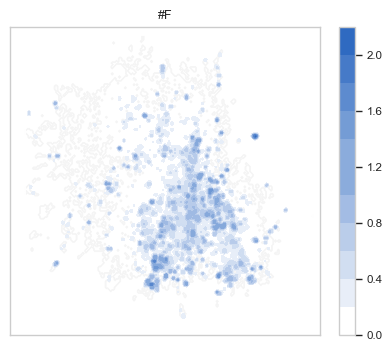

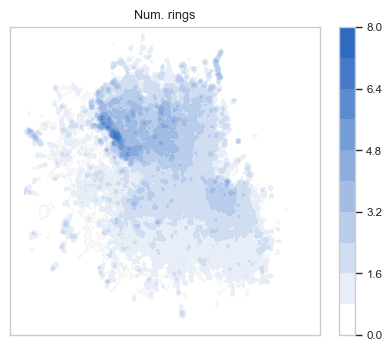

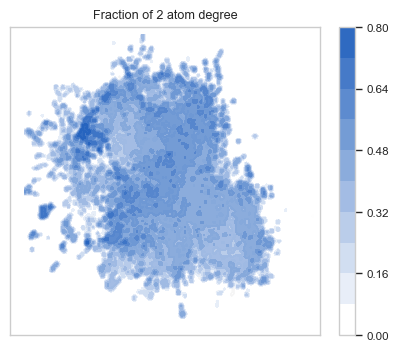

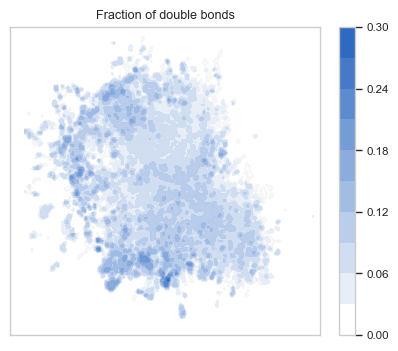

In [107]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import colors
import matplotlib
from msml.utils.plots import init_plotting, get_nature_hex_colors, save_fig
from scipy.ndimage import gaussian_filter
init_plotting(figsize=(5, 4))

levels = 10
cmap = colors.ListedColormap(sns.blend_palette(['white', get_nature_hex_colors()[0]], n_colors=levels))
for feature in ['#C', '#N', '#Cl', '#I', '#P', '#F', 'Num. rings', 'Fraction of 2 atom degree', 'Fraction of double bonds']:
    x_bins, y_bins, grid = bin_2d_umap(umap_embs, feature=feature)
    plt.contour(x_bins[1:], y_bins[1:], gaussian_filter(grid_contour, sigma=0.05), levels=levels, linewidths=0.2, colors='black', zorder=1)
    cnt = plt.contourf(x_bins[1:], y_bins[1:], gaussian_filter(grid, sigma=0.7), levels=levels, cmap=cmap, alpha=0.96, zorder=2, linewidths=0)
    # This is the fix for the white lines between contour levels
    for c in cnt.collections:
        c.set_edgecolor("face")
    plt.grid(None)
    plt.xticks([])
    plt.yticks([])
    cbar = plt.colorbar()
    # if '#' in feature:
    #     # cbar.ax.locator_params(axis='y', nbins=3 if  <= 10 else 5)
    #     max_val = round(grid.max())
    #     print(np.linspace(0, max_val, max_val - 1 if max_val <= 4 else 5))
    #     cbar.set_ticks(np.linspace(0, max_val, max_val - 1 if max_val <= 4 else 5))
    plt.xlim(x_bins[0] - 1, x_bins[-1] + 0.5)
    plt.ylim(y_bins[0] + 0.5, y_bins[-1] + 0.5)
    plt.title(feature)
    save_fig(f'umap_dreams_{feature.replace(" ", "_").replace(".", "")}.svg')
    plt.show()

In [461]:
df['Mean atom degree descrtized'] = df['Mean atom degree'].apply(lambda d: 2 if d == 2 else 1 if d < 2 else 3)

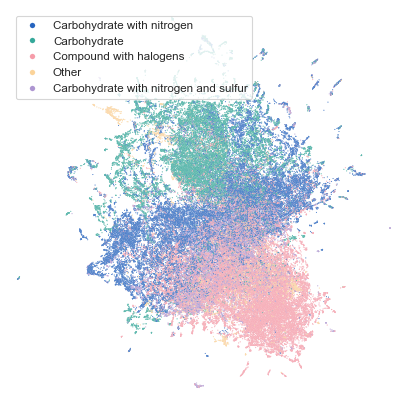

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
from msml.utils.plots import init_plotting, get_nature_hex_colors, save_fig
init_plotting(figsize=(5, 5))
palette = get_nature_hex_colors()
palette[4] = '#AD95D1'

def mol_type(f):
    if is_carbohydrate(f):
        return 'Carbohydrate'
    elif set(f.keys()) <= {'C', 'H', 'O', 'N'}:
        return 'Carbohydrate with nitrogen'
    elif set(f.keys()) <= {'C', 'H', 'O', 'N', 'S'} and 'N' in f and 'S' in f:
        return 'Carbohydrate with nitrogen and sulfur'
    elif is_halogenated(f):
        return 'Compound with halogens'
    else:
        return 'Other'
df['Mol type'] = df['FORMULA'].apply(mol_type)
# df['Num. rings (classes)'] = df['Num. rings'].apply(lambda n: str(n) if n <= 3 else 'More')

sns.scatterplot(
    x=umap_embs[:, 0],
    y=umap_embs[:, 1],
    hue=df['Mol type'],
    palette=palette,
    # markers={'Carbohydrate': 'o', 'Halogenated': 'X', 'Other': 'D'},
    alpha=1,
    s=0.6,
)
min_x, max_x = min(umap_embs[:, 0]), max(umap_embs[:, 0])
# min_x, max_x = 2.1, 17.5
margin_x = (max_x - min_x) * 0.02
min_y, max_y = min(umap_embs[:, 1]), max(umap_embs[:, 1])
# min_y, max_y = -5.03, max(umap_embs[:, 1])
margin_y = (max_y - min_y) * 0.02
plt.xlim(min_x - margin_x, max_x + margin_x)
plt.ylim(min_y - margin_y, max_y + margin_y)
plt.grid(None)
plt.xticks([])
plt.yticks([])
# plt.xlabel('UMAP 1')
# plt.ylabel('UMAP 2')
plt.legend(markerscale=5)
# plt.legend('',frameon=False)
plt.box(False)
# save_fig('umap_dreams.png', dpi=700)
plt.show()

/var/folders/73/x57b4d9x09qbcqjjd5ccz_6r0000gn/T/ipykernel_6806/3465464863.py:19: UserWarning: The palette list has more values (5) than needed (4), which may not be intended.
  sns.scatterplot(


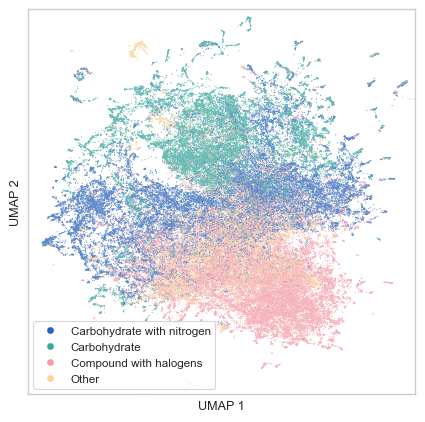

In [108]:
import seaborn as sns
import matplotlib.pyplot as plt
from msml.utils.plots import init_plotting, get_nature_hex_colors, save_fig
init_plotting(figsize=(5, 5))
palette = get_nature_hex_colors()

def mol_type(f):
    if is_carbohydrate(f):
        return 'Carbohydrate'
    elif set(f.keys()) <= {'C', 'H', 'O', 'N'}:
        return 'Carbohydrate with nitrogen'
    elif is_halogenated(f):
        return 'Compound with halogens'
    else:
        return 'Other'
df['Mol type'] = df['FORMULA'].apply(mol_type)
# df['Num. rings (classes)'] = df['Num. rings'].apply(lambda n: str(n) if n <= 3 else 'More')

sns.scatterplot(
    x=umap_embs[:, 0],
    y=umap_embs[:, 1],
    hue=df['Mol type'],
    palette=palette,
    # markers={'Carbohydrate': 'o', 'Halogenated': 'X', 'Other': 'D'},
    alpha=1,
    s=0.5,
)
# min_x, max_x = min(umap_embs[:, 0]), max(umap_embs[:, 0])
min_x, max_x = 2.1, 17.5
margin_x = (max_x - min_x) * 0.02
# min_y, max_y = min(umap_embs[:, 1]), max(umap_embs[:, 1])
min_y, max_y = -5.03, max(umap_embs[:, 1])
margin_y = (max_y - min_y) * 0.02
plt.xlim(min_x - margin_x, max_x + margin_x)
plt.ylim(min_y - margin_y, max_y + margin_y)
plt.grid(None)
plt.xticks([])
plt.yticks([])
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.legend(markerscale=7)
plt.box(True)
save_fig('umap_dreams.png', dpi=700)
plt.show()

EXACT MASS
Axis 0


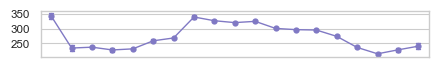

Axis 1


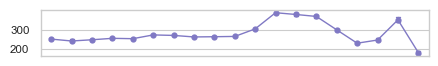

Num. rings
Axis 0


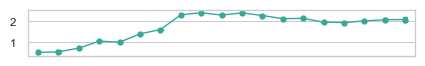

Axis 1


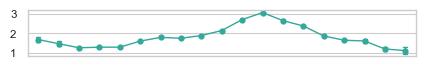

In [106]:
# split interval from x to y to 10 bins
init_plotting(figsize=(5, 0.6))

for feature in ['EXACT MASS', 'Num. rings']:
    print(feature)
    color = palette[4] if feature == 'EXACT MASS' else palette[1]
    for ax_i in range(2):
        print(f'Axis {ax_i}')
        if ax_i == 0:
            min_ax, max_ax = min_x, max_x
        else:
            min_ax, max_ax = min_y, max_y
        umap_ax_bins = np.linspace(min_ax, max_ax, 20)
        masses, bins = [], []
        for i in range(1, len(umap_ax_bins)):
            ax_min, ax_max = umap_ax_bins[i - 1], umap_ax_bins[i]
            idx = np.where((umap_embs[:, ax_i] >= ax_min) & (umap_embs[:, ax_i] < ax_max))[0]
            masses.extend(df.iloc[idx][feature].tolist())
            bins.extend([(ax_max - ax_min) / 2 + ax_min] * len(df.iloc[idx][feature]))
            # print(df.iloc[idx]['EXACT MASS'].mean())
            # print(f'{ax_min}-{ax_max}: {len(df[(umap_embs[:, ax_i] >= ax_min) & (umap_embs[:, ax_i] < ax_max)])}')
            # sns.set(style="ticks", rc={"lines.linewidth": 0.7})
            if ax_i == 1 and feature == 'EXACT MASS':
                plt.yticks([200, 300])
        sns.pointplot(x=bins, y=masses, markers='o', errorbar=('ci', 99), capsize=0.2, markersize=2, markeredgewidth=2.5, linewidth=1, color=color)
        plt.xticks(rotation=90)
        plt.xticks([])
        save_fig(f'umap_dreams_ax_{ax_i}_{feature.replace(".", "").replace(" ", "_")}.svg')
        # plt.box(False)
        plt.show()